In [1]:
options(repr.plot.width=8,repr.plot.height=4)

# Trabajo Práctico Final 
## Ciencias de Datos con R: Fundamentos Estadísticos 

Martin A. Miguel

## Introducción - Dataset

En este trabajo final proponemos trabajar con una base de datos de improvisaciones de jazz. Para cada improvisación contamos con información sobre la canción original como el nombre, el estilo, la métrica y el tempo; entre otras cosas. Además tenemos para cada nota de la improvisación conocemos su duración en segundos, el valor de su altura y su posición en el compás; entre otras cosas.

Para mas información ver el link del dataset: http://jazzomat.hfm-weimar.de/index.html

#### Dependencia de librerías

El siguiente notebook utiliza algunas bibliotecas externas. En la siguiente celda se encuentran las instrucciones de instalación, en caso que falte alguna.

In [2]:
#install.packages("RSQLite")
#install.packages("bbmle")
#install.packages("caret", dependencies=T)

### Canciones por estilo

Veamos como se distribuyen las improvisaciones entre los estilos. La información de cada solo se encuentra en la tabla __solo_info__ de la base de datos.

In [3]:
library(DBI)
con <- dbConnect(RSQLite::SQLite(), "datasets/wjazzd.db")

In [4]:
solos <- dbReadTable(con, "solo_info")

In [209]:
solos.styles <- data.frame(table(solos$style))
colnames(solos.styles)[1] <- 'Style'
solos.styles

Style,Freq
BEBOP,56
COOL,54
FREE,5
FUSION,20
HARDBOP,76
POSTBOP,147
SWING,66
TRADITIONAL,32


### Canciones por métrica

Adicionalmente podemos ver como se agrupan las canciones de las que se generaron las improvisaciones según su [métrica](https://es.wikipedia.org/wiki/M%C3%A9trica_(m%C3%BAsica)). La métrica establece cuantos tiempos del pulso componen un compás.

In [6]:
solos.metrics <- data.frame(table(solos$signature))
colnames(solos.metrics)[1] <- 'Metric'
solos.metrics

Metric,Freq
,8
3/4,8
4/4,435
5/4,1
6/4,1
6/8,1
9/4,2


## Propuesta: clasificar por distribución de la duración de las notas por estilo.

Queremos ver si los estilos se diferencian por información en las improvisaciones. Considerando la distribución desproporcionada de canciones en 4/4, nos restringimos a este subconjunto de solos.

In [7]:
solos.44 <- solos[solos$signature == '4/4',]

### Ejemplos por estilo

Presentamos algunos ejemplos aleatorios por estilo para poder escucharlos. En particular, pueden [bajarse](http://jazzomat.hfm-weimar.de/download/RELEASE2.0_mid_unquant.zip) las improvisaciones en formato MIDI, que puede ser reproducido por algunos reproductores.

In [8]:
set.seed(123)
d <- lapply(unique(solos.44$style), function(s) {
    xs <- solos[solos.44$style == s, ][sample(1:sum(solos$style == s), 5), ]
    out <- sapply(1:nrow(xs), function(i) { sprintf('%s - %s', xs[i, 'performer'], xs[i, 'title']) })
})
d <- data.frame(d)
colnames(d) <- unique(solos.44$style)
d

COOL,SWING,TRADITIONAL,POSTBOP,FUSION,HARDBOP,BEBOP
Freddie Hubbard - Speak No Evil,Benny Carter - Just Friends,Phil Woods - On a Slow Boat to China,Wayne Shorter - Dolores,Steve Coleman - Cross-Fade,Pat Martino - Along Came Betty,Sonny Rollins - I'll Remember April
Sonny Rollins - St. Thomas,Dickie Wells - Dickie's Dream,Kenny Dorham - Punjab,Don Ellis - I Love You,Miles Davis - Bitches Brew,Lee Konitz - Bop Goes to Leesel,Sonny Rollins - Airegin
Kenny Wheeler - Slipped again,Lester Young - Dickie's Dream,Lionel Hampton - Avalon,Branford Marsalis - Gutbucket Steepy,Michael Brecker - Naked Soul,Michael Brecker - I Mean You,Johnny Hodges - Bunny
Steve Coleman - Double Vision,Pepper Adams - You'd Be So Nice to Come Home to,Kenny Garrett - Brother Hubbard,Freddie Hubbard - Down Under,Sonny Stitt - Blue Mode,Gerry Mulligan - The Red Door,Miles Davis - Tune Up
Steve Coleman - Processional,Coleman Hawkins - My Blue Heaven,Bix Beiderbecke - Riverboat Shuffle,NA - NA,Michael Brecker - Midnight Voyage,Clifford Brown - Jordu,Charlie Parker - Billie's Bounce


### Analisis global de la duración de las notas

Queremos ver si hay diferencias notables entre las improvisaciones de distintos estilos. Empezamos enfocándonos en la duración de las notas. Observamos primero la duración de las notas para el total de las improvisaciones.
La información de cada nota de cada improvisación se encuentra en la tabla __melody__ de la base de datos. La información general del solo se relaciona con la información de notas mediante la columna `melid`.

In [9]:
melody <- dbReadTable(con, 'melody')

In [10]:
melody.44 <- melody[melody$melid %in% solos.44$melid,]

In [11]:
x <- merge(melody.44, solos.44, by.x='melid', by.y='melid') # Unimos las notas con el estilo de la canción a la que 
duration.and.style <- x[c('melid', 'duration', 'style')]

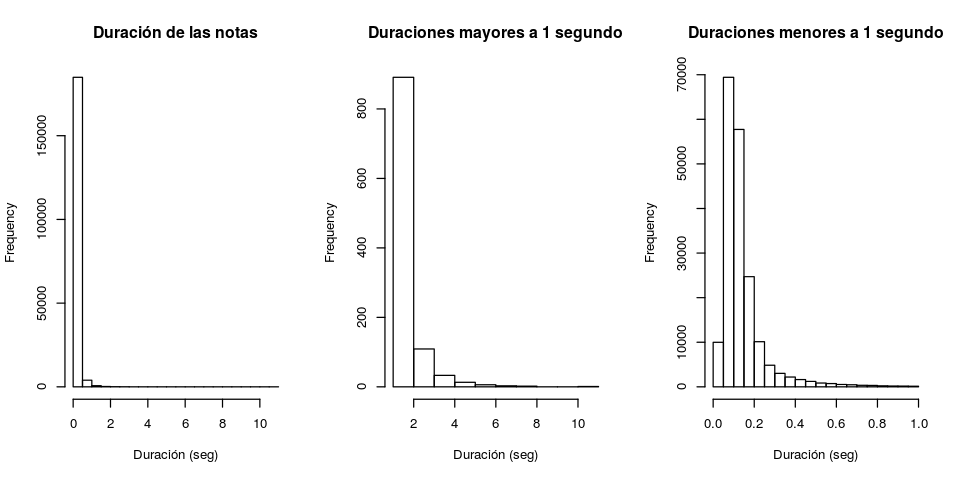

In [12]:
par(mfrow=c(1,3))
hist(duration.and.style$duration, main='Duración de las notas', xlab='Duración (seg)')
hist(duration.and.style$duration[duration.and.style$duration > 1],
    main='Duraciones mayores a 1 segundo', xlab='Duración (seg)')
hist(duration.and.style$duration[duration.and.style$duration <= 1],
    main='Duraciones menores a 1 segundo', xlab='Duración (seg)')

Estimamos la densidad de la distribución de la duración de las notas utilizando un modelo no paremétrico.

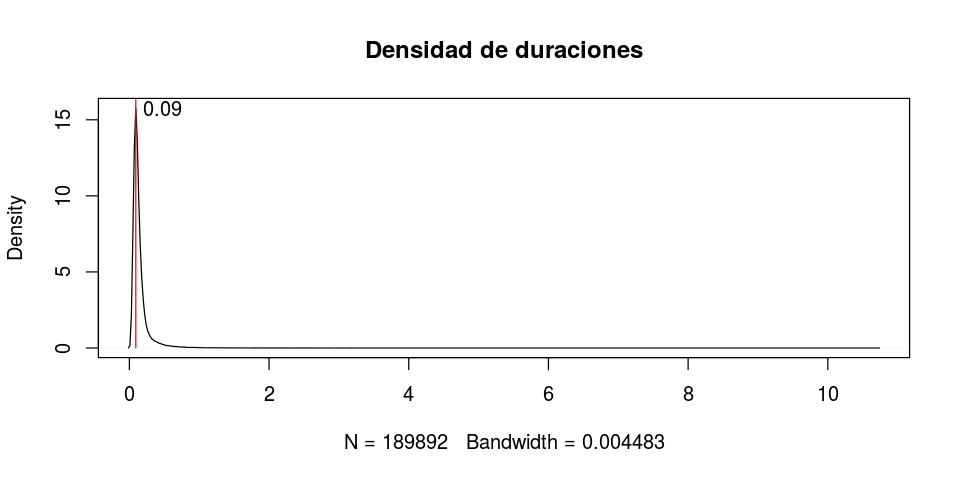

In [13]:
d <- density(duration.and.style$duration)
plot(d,  main='Densidad de duraciones')
x.max <- d$x[which.max(d$y)]
lines(rep(x.max, 2), c(0, max(d$y) + 2), col='red')
text(x.max + 0.1, max(d$y), labels=c(round(x.max,2)), adj=c(0, 0.5))

Asumimos que la distribución es una gamma y estimamos los parámetros. Nos concentramos en las duraciones menores a 1 s. Usamos los estimadores de momentos.

In [14]:
gamma.alpha.mme.est <- function(ma) {
    (mean(ma) ** 2) / (mean((ma - mean(ma)) ** 2))
}
gamma.lambda.mme.est <- function(ma) {
    (mean(ma) ** 1) / (mean((ma - mean(ma)) ** 2))
}

gamma.ma <- rgamma(10000, 3, 5)
stopifnot(abs(gamma.alpha.mme.est(gamma.ma) - 3) < 0.2)
stopifnot(abs(gamma.lambda.mme.est(gamma.ma) - 5) < 0.2)

[1] "alpha = 1.63, lambda = 11.67"


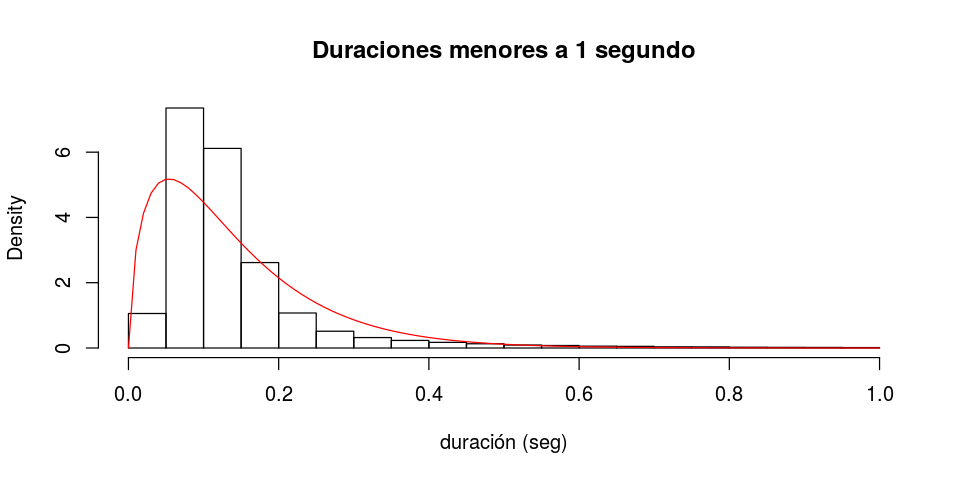

In [15]:
menor_1 = duration.and.style$duration[duration.and.style$duration < 1]
duracion.alpha.mme.est <- gamma.alpha.mme.est(menor_1)
duracion.lambda.mme.est <- gamma.lambda.mme.est(menor_1)
print(sprintf('alpha = %.2f, lambda = %.2f', duracion.alpha.mme.est, duracion.lambda.mme.est))
hist(duration.and.style$duration[duration.and.style$duration < 1], 
     main='Duraciones menores a 1 segundo', xlab='duración (seg)', freq=F)
xs <- seq(0.0, 1, 0.01)
lines(xs, dgamma(xs, duracion.alpha.mme.est, duracion.lambda.mme.est), col='red')

Viendo que la densidad no queda tan ajustada al histograma, probamos con los estimadores de máxima verosimilitud.

In [16]:
library(bbmle)

Loading required package: stats4


In [17]:
gamma.alpha.nll = function(a, ma=duration.and.style$duration) {
    ll = length(ma) * a * (log(a) - log(mean(ma))) - length(ma) * lgamma(a) + (a - 1) * sum(log(ma)) - a * length(ma)
    -ll
}
emv = mle2(gamma.alpha.nll, start=list(a=duracion.alpha.mme.est), data=list(ma=duration.and.style$duration))

Warning message in log(a):
“NaNs produced”

In [18]:
duracion.alpha.emv.est = coef(emv)
duracion.lambda.emv.est = duracion.alpha.emv.est / mean(menor_1)

[1] "alpha = 2.33, lambda = 16.67"


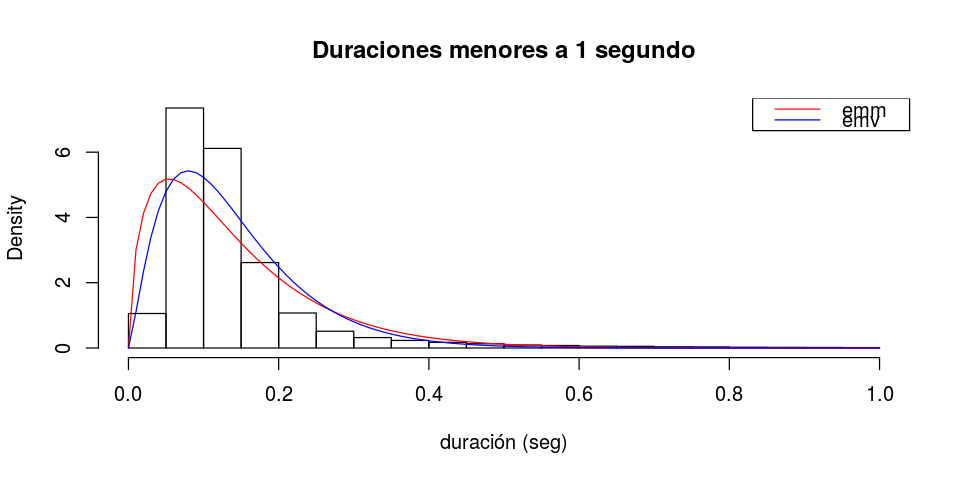

In [19]:
print(sprintf('alpha = %.2f, lambda = %.2f', duracion.alpha.emv.est, duracion.lambda.emv.est))
hist(duration.and.style$duration[duration.and.style$duration < 1], 
     main='Duraciones menores a 1 segundo', xlab='duración (seg)', freq=F)
xs <- seq(0.0, 1, 0.01)
lines(xs, dgamma(xs, duracion.alpha.mme.est, duracion.lambda.mme.est), col='red')
lines(xs, dgamma(xs, duracion.alpha.emv.est, duracion.lambda.emv.est), col='blue')
legend('topright', legend=c('emm', 'emv'), lty=rep(1, 2), lwd=rep(1, 2), col=c('red', 'blue'))

### Duración de las notas por estilo.

Luego de observar como se distribuyen las notas en general, vemos si hay diferencia en la distribución de las duraciones según estilo.

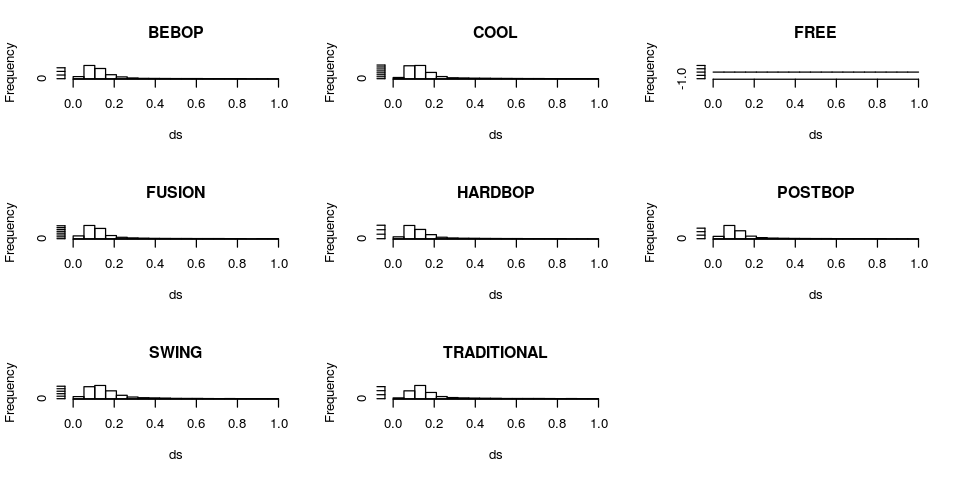

In [20]:
par(mfrow=c(ceiling(length(solos.styles[,1]) / 3), 3))
duration_1.and.style = duration.and.style[duration.and.style$duration < 1,]
breaks = seq(0, 1, length.out=20)
for (s in solos.styles[,1]) {
    ds = duration_1.and.style$duration[duration_1.and.style$style == s]
    hist(ds, breaks=breaks, main=s)
}

Nuevamente estimamos la densidad de forma no paramétrica para cada estilo.

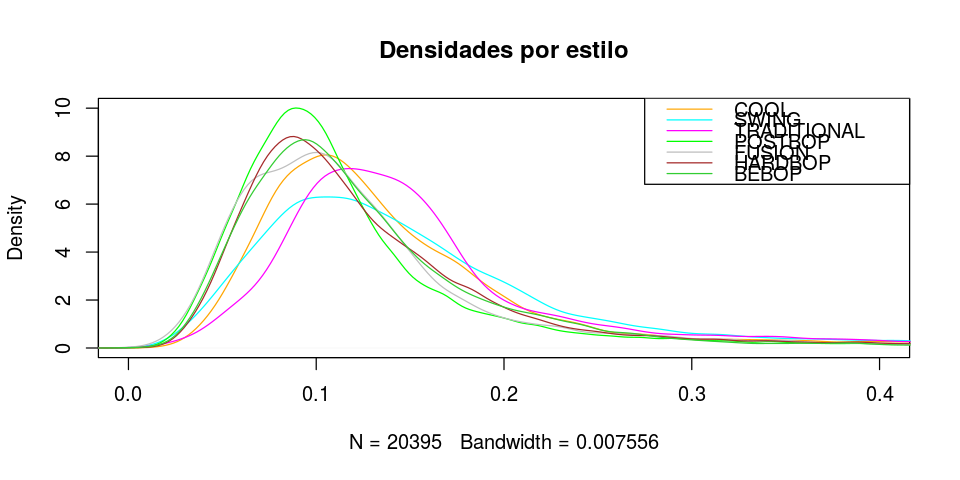

In [21]:
styles <- unique(solos.44$style)
cols = c('orange', 'cyan', 'magenta', 'green', 'grey', 'brown', 'limegreen', 'blue')
ymax = 0
for (style_idx in 1:length(styles)) {
    style <- styles[style_idx]
    durations <- duration_1.and.style[duration_1.and.style$style == style,]
    ymax = max(density(durations$duration)$y, ymax)
}
for (style_idx in 1:length(styles)) {
    style <- styles[style_idx]
    durations <- duration_1.and.style[duration_1.and.style$style == style,]
    d <- density(durations$duration)
    if (style_idx == 1) {
        plot(d, ylim=c(0, ymax), xlim=c(0, 0.4), col=cols[style_idx], main='Densidades por estilo')
    } else {
        lines(d, col=cols[style_idx])
    }
}
legend('topright', legend=styles, lty=rep(1, length(styles)), lwd=rep(1, length(styles)), col=cols)

### Clasificador de máxima verosimilitud por duración de notas

Vamos a probar clasificar las canciones utilizando máxima verosimilitud respecto de las densidades calculadas. 

Definimos los siguientes términos:
* El conjunto de melodías: $\mathcal{M} = \{ m^1, m^2, ..., m^K \}$
* Las notas de la melodía $k$: $\{m^k_1, m^k_2, ..., m^k_{n_k}\}$.
* El conjunto de estilos de solos: $\mathcal{S}$
* La función de densidad de duración del estilo $s$: $f_s$

Clasificamos con la regla:

$$ h(m) = \underset{s \in S}{argmax} \sum_{i = 1}^{n} \log{f_s(m_i)} $$

No tenemos en cuenta probabilides a priori de los estilos ya que no consideramos la muestra de nuestros datos como representativos de la población. Por tanto, consideramos a los estilos como equiprobables. Al mismo tiempo, queremos ver la capacidad de discriminación de los estilos solamente por la información de las duraciones. 

En particular, vamos a hacer CV de 10 folds para evaluar el poder del método. También vamos a restringirnos a canciones en 4/4.

In [22]:
cv.table <- data.frame(table(solos.44$style))
cv_count = 10
cv_factor = 1/cv_count
cv.table <- cbind(cv.table, ceiling(cv.table[,2] * (1 - cv_factor)))
cv.table <- cbind(cv.table, floor(cv.table[,2] * cv_factor))
colnames(cv.table) <- c('Estilo', 'ejemplos', 'tamaño entrenamiento', 'tamaño evaluación')
cv.table
stopifnot(cv.table[,3] + cv.table[,4] == cv.table[,2]) # train + test = set

cv.eval_sizes = list()
for (style_idx in 1:length(cv.table[,1])) {
    style = as.character(cv.table[style_idx, 1])
    cv.eval_sizes[[style]] = cv.table[style_idx, 4]
}

Estilo,ejemplos,tamaño entrenamiento,tamaño evaluación
BEBOP,55,50,5
COOL,54,49,5
FUSION,18,17,1
HARDBOP,75,68,7
POSTBOP,135,122,13
SWING,66,60,6
TRADITIONAL,32,29,3


El estilo `FREE` desapareció porque ninguno de sus 5 solos tenía métrica definida.

In [23]:
cv.melids = list()
cv.styles = cv.table[,1]
set.seed(123)
for (style in cv.styles) {
    style_melids = solos.44[solos.44$style == style,]$melid
    cv.melids[[style]] = sample(style_melids, length(style_melids))
}

In [240]:
# Función que devuelve el estilo MAP de la canción 'melid' dada las duraciones de los 
# entrenamientos de los estilos 'train_durations'
colors = c('red', 'blue', 'green', 'yellow', 'black', 'purple', 'orange')
predict_style = function(melid, train_durations, bw=0.2, duration_pre_f=function(x) {x}) {
    style.scores = sapply(1:length(cv.styles), function (style_idx) {
        style = cv.styles[style_idx]
        d <- density(train_durations[[style]], bw=bw)
        xs <- duration_pre_f(melody$duration)[melody$melid == melid]
        ys <- approx(d$x, d$y, xs)$y  # Analogo a approxfun y density(from, to) de Lista 9, ej 10
        
        ys <- ys[!is.na(ys)]
        ys <- ys[ys > 0]
        
        # https://stackoverflow.com/questions/28077500/find-the-probability-density-of-a-new-data-point-using-density-function-in-r
        sum(log(ys))
    })
    return(as.character(cv.styles[which.max(style.scores)]))
}

Nos encontramos con dos notas con duraciones particularmente altas (~3s y ~10s), lo cual es problemático porque las densidades estimadas no-paramétricas no ven ese valor y no pueden asignarle probabilidad. Resolvemos la situación considerando estos valores como outliers y por tanto eliminándolos de la muestra. Esto tiene sentido desde un punto de vista musical. Tendría sentido pensar que son errores de medición.

A continuación realizamos la convalidación cruzada y evaluamos sus puntajes. El puntaje usado es `accuracy` (porcentaje de ejemplos clasificados correctamente).

In [249]:
# Ejecuta la convalidacion cruzada para los parámetros 'cv_count' dados y el bandwidth (bw) de densidad pasado
# por parámetro. 
# Devuevle una lista indexada por índice de cv con dos listas internas 'predicted' y 'truth' con las etiquetas
# predichas y verdaderas para los ejemplos vistos en cada cv.
cv.calc <- function(bw=0.2, duration_pre_f=function(x) {x}) {
    cv.scores = list()
    for (cv_idx in 1:cv_count) {  # Para cada CV
        train_durations = list()
        test_solos = list()
        for (style in cv.styles) {  # separo los solos para evaluación y entrenamiento
            eval_size = cv.eval_sizes[[style]]
            test_solos_idx = (1 + (cv_idx - 1) * eval_size):(cv_idx * eval_size)
            stopifnot(eval_size == length(test_solos_idx))
            eval_melids = cv.melids[[style]][test_solos_idx]
            train_melids = cv.melids[[style]][-1 * test_solos_idx]
            train_durations[[style]] = duration_pre_f(melody$duration)[melody$melid %in% train_melids]
            test_solos[[style]] = eval_melids
        }
        predicted = c()
        truth = c()
        for (style in cv.styles) {
            for (melid in test_solos[[style]]) {
                pred_style = predict_style(melid, train_durations, bw=bw, duration_pre_f=duration_pre_f)
                truth = c(truth, style)
                predicted = c(predicted, pred_style)
            }
        }
        stopifnot(length(truth) == length(predicted))
        stopifnot(length(truth) == 40)
        cv.scores[[cv_idx]] = list(predicted=predicted, truth=truth)
    }
    return(cv.scores)
}

In [212]:
cv.scores <- cv.calc()

In [213]:
# Devuelve un vector de los errores medios para cada par de vectores de resultados de la convalidación cruzada
# 'cv.scores' es una lista de objetos con listas 'predicted' y 'truth' de etiquetas de estilos para los solos
# clasificados.
all.cv.scores <- function(cv.scores) {
    sapply(cv.scores, function(x) mean(x$predicted == x$truth))
}

In [214]:
sprintf('Cross validation accuracy (bw=0.2): %.2f', mean(all.cv.scores(cv.scores)))
all.cv.scores(cv.scores)

[1] "Cross validation accuracy (bw=0.2): 0.22"

[1] 0.175 0.150 0.225 0.225 0.200 0.250 0.250 0.225 0.175 0.300

La precisión es baja, aunque en principio es mejor que el clasificador que asigna clases de manera aleatoria. El mismo tendría una precisión esperada 0.142. Esto es esperable ya que las curvas de densidad de cada $f_s$ eran bastante similares. 

Para ver un poco mejor los resultados realizamos una matriz de confusión con la conjunción de todos los resultados de los CV.

In [215]:
library(caret)

In [216]:
cv.scores.all = list(predicted = c(sapply(cv.scores, function(x) x$predicted)),
    truth=c(sapply(cv.scores, function(x) x$truth)))
stopifnot(length(cv.scores.all$predicted) == 40 * cv_count)
stopifnot(length(cv.scores.all$truth) == 40 * cv_count)

In [217]:
confusionMatrix(cv.scores.all$predicted, cv.scores.all$truth)$table

             Reference
Prediction    BEBOP COOL FUSION HARDBOP POSTBOP SWING TRADITIONAL
  BEBOP          35   26      3      39      70    35          20
  COOL            3    4      4       5       8     5           1
  FUSION          0    0      0       0       0     0           0
  HARDBOP         0    0      0       0       0     0           0
  POSTBOP         7    2      2      15      33     2           0
  SWING           0    2      0       5       1     8           2
  TRADITIONAL     5   16      1       6      18    10           7

Vemos que la clasificación se separa principalmente en `BEBOP`, `POSTBOP` y `TRADITIONAL`. 

Nos proponemos hacer una grilla en el valor de `bandwidth` utilizado para la estimación de la densidad de las duraciones por estilo para ver si mejora el resultado final.

In [218]:
bws <- seq(0.001, 0.8, length.out=50)
bws.cv_mean_score <- sapply(bws, function(bw) mean(all.cv.scores(cv.calc(bw))))

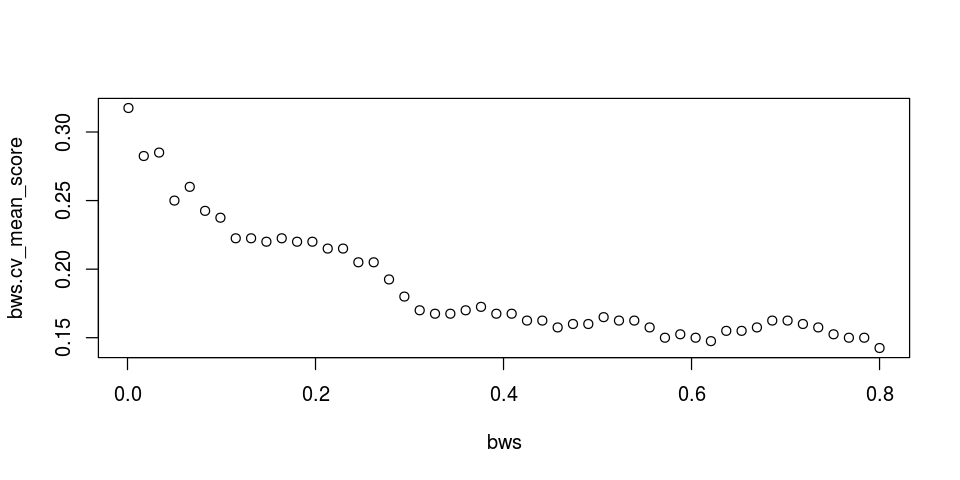

In [219]:
plot(bws, bws.cv_mean_score)

Vemos que reducir el tamaño del bandwidth mejora un poco los resultados. Los analizamos viendo la matriz de confusión.

In [220]:
cv.scores.h_opt = cv.calc(0.001)

In [221]:
cv.scores.h_opt.all = list(predicted = c(sapply(cv.scores.h_opt, function(x) x$predicted)),
    truth=c(sapply(cv.scores.h_opt, function(x) x$truth)))

In [222]:
confusionMatrix(cv.scores.h_opt.all$predicted, cv.scores.h_opt.all$truth)$table

             Reference
Prediction    BEBOP COOL FUSION HARDBOP POSTBOP SWING TRADITIONAL
  BEBOP           0    0      0       0       0     0           0
  COOL            0    0      0       0       0     0           0
  FUSION          4    2      0       2       7     0           0
  HARDBOP         0    0      0       0       0     0           0
  POSTBOP        44   37      9      60     118    51          24
  SWING           2   11      1       8       5     9           6
  TRADITIONAL     0    0      0       0       0     0           0

In [223]:
sprintf('Cross validation accuracy (bw=%.3f): %.2f', 0.001, mean(all.cv.scores(cv.scores.h_opt)))
all.cv.scores(cv.scores.h_opt)

[1] "Cross validation accuracy (bw=0.001): 0.32"

[1] 0.325 0.325 0.375 0.175 0.325 0.325 0.325 0.325 0.325 0.350

Al optimizar la clasificación modificando el `bandwidth`, vemos que la mejora se debe a que la mayoría de los ejemplos pasan a ser clasificados como POSTBOP, que tiene la mayor cantidad de ejemplos en la muestra.

## Revisitando las duraciones

En música, la duración de las notas se produce relativo a la velocidad de la canción. Las canciones tienen un atributo llamado BPM (beats per minute) que define la cantidad de pulsos que suenan en un minuto. Su inversa es la frecuencia del pulso, o su duración. Las notas se suelen pensar como fracciones del pulso (1/4, 2, 1/8, 3/4, etc.).

En la base de datos, para cada nota tenemos la duración del pulso en ese momento de la canción. Si dividimos su duración por la duración del pulso tenemos la duracción relativa al pulso.

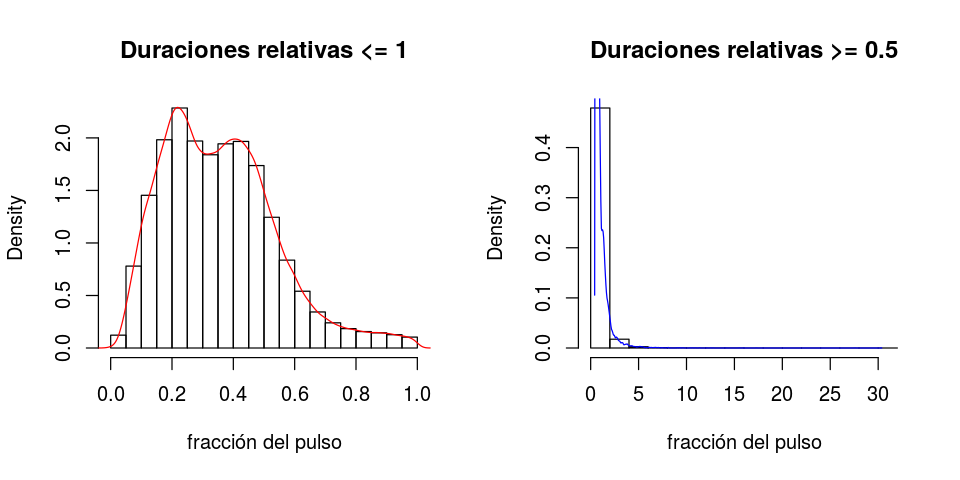

In [64]:
rel.durations <- melody.44$duration / melody.44$beatdur
par(mfrow=c(1, 2))

hist(rel.durations[rel.durations <= 1], main='Duraciones relativas <= 1', xlab='fracción del pulso', freq=F)
lines(density(rel.durations[rel.durations <= 1]), col='red')

hist(rel.durations[rel.durations >= 0.5], main='Duraciones relativas >= 0.5', xlab='fracción del pulso', freq=F)
lines(density(rel.durations[rel.durations >= 0.5]), col='blue')

Si bien en la música es común que las notas tengan duraciones mayores al largo de un pulso, se ve que en el conjunto de estas intrepretaciones suelen durar bastante menos.

Es esperable que la distribución de la duración de notas tenga modas en las fracciones más comunes (1/2, 1/4 y 1/8). Luego, por características de la interpretación de jazz, también es esperable que las duraciones tiendan a ser un poco más cortas que la esperada. Esto es, si musicalmente la duración está anotada como 1/2 de la duración del pulso, es esperable que en la interpretación la nota dure menos.

### Aproximando las duraciones con normales

Viendo el comportamiento multimodal en el primer histograma sumado a que es esperable este comportamiento, vamos a probar aproximar la distribución por mezclas de normales

In [39]:
library(mixtools)

mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.



In [186]:
aprox.by.normals <- function(k, plot=T, maxit=500) {
    colors = c('blue', 'red', 'orange', 'purple')
    norm.approx <- normalmixEM(rel.durations[rel.durations <= 1], k=k, maxit=maxit)

    if (plot) {
        summary(norm.approx)
    }

    xs <- seq(0, 1, 0.01)
    dens = list()
    for (i in 1:k) {
        dens[[i]] <- dnorm(xs, mean=norm.approx$mu[i], sd=norm.approx$sigma[i])
    }

    if (plot) {
        hist(rel.durations[rel.durations <= 1.5], ylim=c(0, max(dens1 + dens2)), freq=F,
             main=sprintf('Duraciones relativas aproximadas por %d normales', k), 
             xlab='Duración respecto del pulso', border='grey')
    }
    
    dens.total <- rep(0, length(xs))
    for (i in 1:k) {
        dens.total <- dens.total + dens[[i]] * norm.approx$lambda[i]
        if (plot) {
            lines(xs, dens[[i]], col=colors[i], lty='dashed')
        }
    }
    if (plot) {
        lines(xs, dens.total, col='black')
    }
    return(norm.approx)
}

In [155]:
set.seed(123)

number of iterations= 151 
summary of normalmixEM object:
          comp 1   comp 2
lambda 0.2939901 0.706010
mu     0.1978439 0.422454
sigma  0.0735327 0.174499
loglik at estimate:  58133.84 


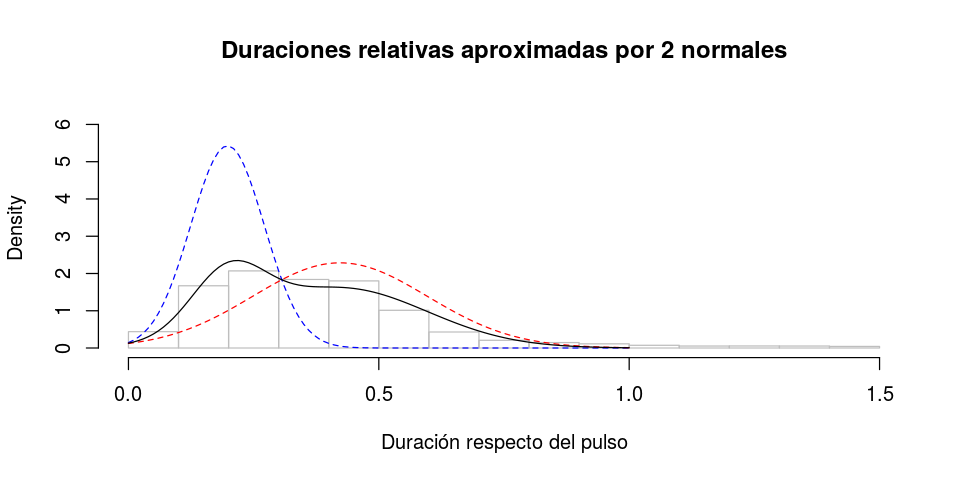

In [160]:
aprox.2 <- aprox.by.normals(2)

number of iterations= 400 
summary of normalmixEM object:
         comp 1    comp 2   comp 3
lambda 0.045982 0.3130053 0.641013
mu     0.817765 0.1830133 0.408002
sigma  0.101856 0.0685301 0.129244
loglik at estimate:  63717.51 


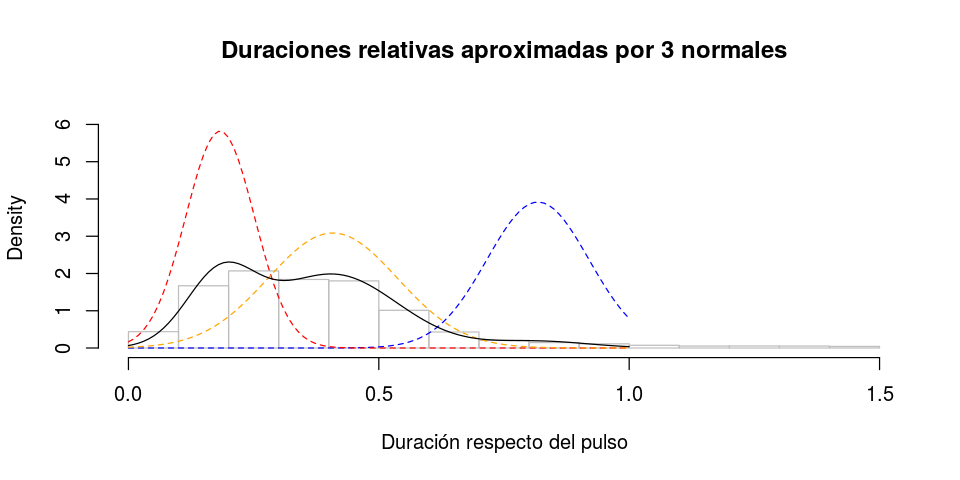

In [161]:
aprox.3 <- aprox.by.normals(3)

WARNING! NOT CONVERGENT! 
number of iterations= 500 
summary of normalmixEM object:
          comp 1    comp 2   comp 3    comp 4
lambda 0.0599930 0.2661874 0.625481 0.0483387
mu     0.0990555 0.2031378 0.411207 0.8110201
sigma  0.0322222 0.0593849 0.125993 0.1050751
loglik at estimate:  64416.86 


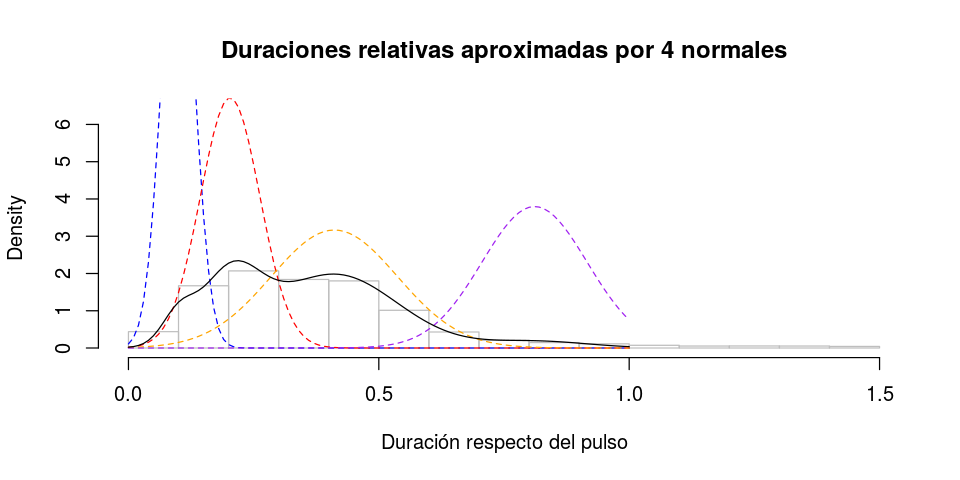

In [162]:
aprox.4 <- aprox.by.normals(4)

In [235]:
x <- rbind(list(aprox.2$mu), list(aprox.3$mu), list(aprox.4$mu))
rownames(x) <- c('2', '3', '4')
'Valores de mu estimados según la cantidad de gaussianas'
x

[1] "Valores de mu estimados según la cantidad de gaussianas"

2,"0.1978439, 0.4224540"
3,"0.8177645, 0.1830133, 0.4080017"
4,"0.09905546, 0.20313781, 0.41120655, 0.81102014"


Si vemos la aproximación con dos gausianas, vemos que las medias están en ~0.2 y ~0.4, lo cual concuerda bastante con nuestra hipótesis de que debería haber modas algo menores a 1/2 y 1/4. 

Cuando agregamos componentes, se repite un poco este comportamiento. Con 4 campanas tenemos medias aproximadamente en 0.1, 0.2, 0.4 y 0.8. Esto podría considerarse cercano a 1/8, 1/4, 1/2 y 1. Estas son subdivisiones muy comunes del pulso. Estaría faltando visibilizar algunos múltiplos de estas, como 3/4 de pulso. Estos múltiplos son algo comunes y seguramente agregen ruido a la muestra.

In [ ]:
ks = 5:10
aprox.others = lapply(ks, function(k) { aprox.by.normals(k, F, 100)})

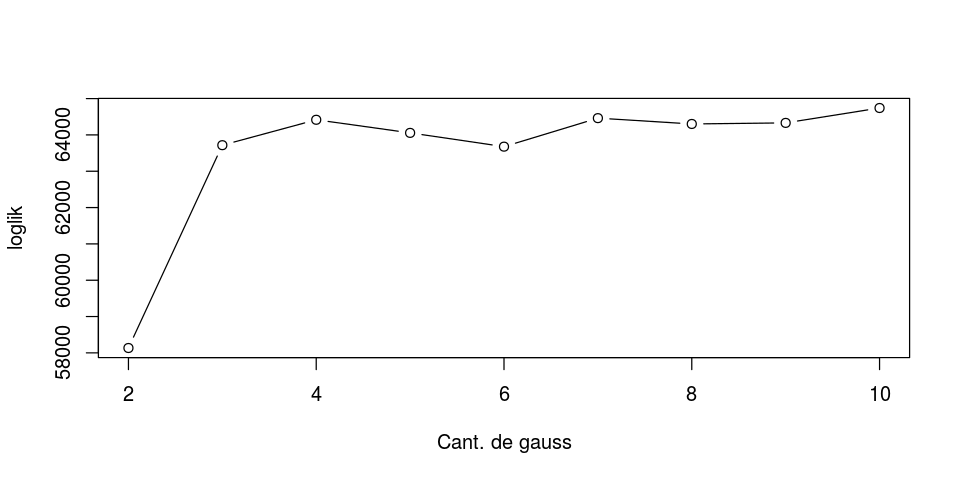

In [200]:
aprox.loglik = sapply(aprox.others, function(a) a$loglik)
plot(c(2, 3, 4, ks), c(aprox.2$loglik, aprox.3$loglik, aprox.4$loglik, aprox.loglik), 
        xlab='Cant. de gauss', ylab='loglik', type='b')

Probamos extender la cantidad de gaussianas para ver si aumenta la explicabilidad (en el sentido de loglik) y vemos que se estanca bastante luego de 3. La última parte de la curva parecería ser overfitteo.

### Clasificando denuevo

Viendo la diferencia de la distribución cuando hacemos las duraciones relativas a la duración del pulso, decidimos probar clasificar denuevo usando esta información.

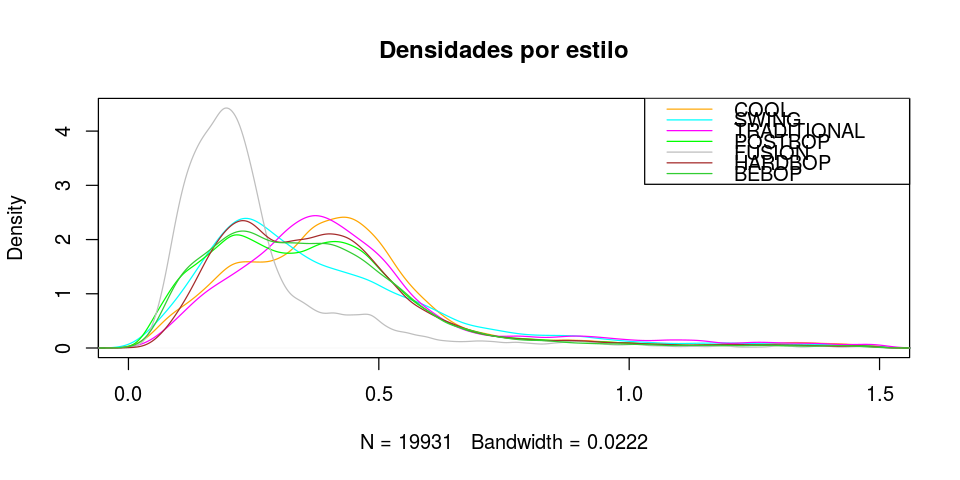

In [259]:
cols = c('orange', 'cyan', 'magenta', 'green', 'grey', 'brown', 'limegreen', 'blue')
ymax = 0
durations_per_style <- list()
for (style_idx in 1:length(styles)) {
    style <- styles[style_idx]
    melody_idxs <- melody$melid %in% solos.44$melid[solos.44$style == style]
    rel.durations <- melody$duration[melody_idxs] / melody$beatdur[melody_idxs]
    rel.durations <- rel.durations[rel.durations <= 1.5]
    durations_per_style[[style]] <- rel.durations
    ymax = max(density(rel.durations)$y, ymax)
}
for (style_idx in 1:length(styles)) {
    style <- styles[style_idx]
    d <- density(durations_per_style[[style]])
    if (style_idx == 1) {
        plot(d, ylim=c(0, ymax), xlim=c(0, 1.5), col=cols[style_idx], main='Densidades por estilo')
    } else {
        lines(d, col=cols[style_idx])
    }
}
legend('topright', legend=styles, lty=rep(1, length(styles)), lwd=rep(1, length(styles)), col=cols)

In [257]:
cv.scores.rel <- cv.calc(duration_pre_f=function(melody_durations) {
    melody_durations / melody$beatdur
})

In [253]:
sprintf('Cross validation accuracy (bw=0.2): %.2f', mean(all.cv.scores(cv.scores.rel)))
all.cv.scores(cv.scores.rel)

[1] "Cross validation accuracy (bw=0.2): 0.14"

[1] 0.125 0.050 0.175 0.250 0.075 0.225 0.100 0.125 0.150 0.175

In [262]:
cv.scores.all.rel = list(predicted = c(sapply(cv.scores.rel, function(x) x$predicted)),
    truth=c(sapply(cv.scores, function(x) x$truth)))
stopifnot(length(cv.scores.all.rel$predicted) == 40 * cv_count)
stopifnot(length(cv.scores.all.rel$truth) == 40 * cv_count)

In [263]:
confusionMatrix(cv.scores.all.rel$predicted, cv.scores.all$truth)$table

             Reference
Prediction    BEBOP COOL FUSION HARDBOP POSTBOP SWING TRADITIONAL
  BEBOP           0    0      1       1       0     0           0
  COOL           16   19      1      13      45    13          13
  FUSION         13    8      7      18      52    17           2
  HARDBOP        14    4      0      20      13     7           2
  POSTBOP         0    0      0       0       0     0           0
  SWING           0    0      1       0       2     0           1
  TRADITIONAL     7   19      0      18      18    23          12

Observamos que la precisión de clasificación bajó a valores parecidos al del clasificador aleatorio. Por otra parte, la clasificación que antes se concentraba en BEBOP y POSTBOP ahora se concentra en COOL, FUSION, HARDBOP y TRADITIONAL.